In [32]:
import sys, os
import serial
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import win32com.client
from astropy.io import fits
import threading
import nbimporter
from picoammeter_control import (
    send_cmd,
    query,
    init_cmds
)
from camera_control_ascom import (
    take_ramp,
    camera_init
)
sys.path.insert(0, os.path.abspath('.'))
sys.path.insert(0, os.path.abspath('filter_wheel_control'))
from filter_wheel_control.wheel_controller import (
    list_devices,
    open_device,
    get_position,
    get_position_count,
    set_position,
    close_device
)

In [29]:
# init filter wheels
print("Finding filter wheel devices...")
devices = list_devices()
if not devices:
    print("No filter wheel devices found.")
    sys.exit(1)

print("Found devices:")
for idx, dev in enumerate(devices):
    print(f" [{idx}] {dev}")


# init filter wheels to empty pos
for i in range(len(devices)):
    handle = open_device(devices[i])
    max_pos = get_position_count(handle)
    print(max_pos)
    if max_pos > 1:
        set_position(handle, 1)
        if max_pos == 6:
            wheel6_port = i
        elif max_pos == 12:
            wheel12_port = i
    close_device(handle)

Finding filter wheel devices...
Found devices:
 [0] COM5
 [1] COM6
 [2] COM4
-1
6
12


In [33]:
camera_init()

You selected: ASCOM.ASICamera2.Camera


KEITHLEY INSTRUMENTS INC.,MODEL 6485,4070587,C01   Jun 23 2010 12:22:00/A02  /H
relative std: 4.1152957291069085e-11


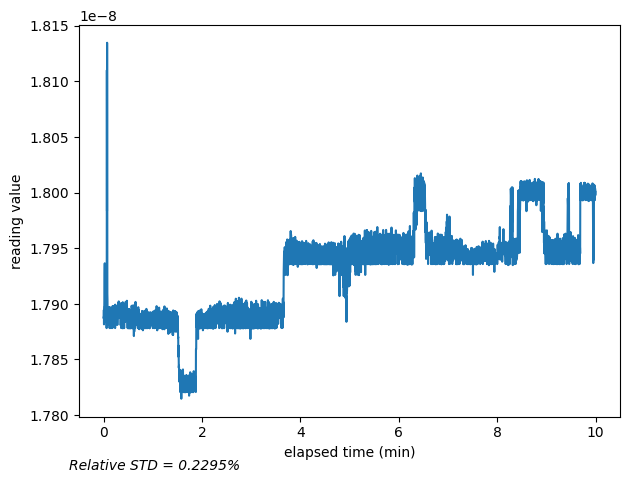

saved to path


In [38]:
""" to calculate picoammeter stability """
# Open serial connection
ser = serial.Serial(
    port='COM5',         # Replace with your actual port
    baudrate=9600,
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    timeout=2,
    xonxoff=False,
    rtscts=False,
    dsrdtr=False
)

init_cmds(ser)

# read_time = 30 # time in minutes to read for
# num_of_reads = round(417*read_time)
# readings = np.zeros(num_of_reads)
# times = np.zeros(num_of_reads)
#
# # Trigger a read and fetch result
# for i in range(num_of_reads):
#     time.sleep(0.004)
#     current = query(ser,'READ?')
#     readings[i] = current
#     times[i] = time.time()

read_time       = 10          # minutes
sample_interval = 0.004          # seconds between reads
start_time = time.time()
end_time   = start_time + read_time * 60
readings_1 = []
times_1    = []
while time.time() < end_time:
    time.sleep(sample_interval)
    current = query(ser, 'READ?')
    readings_1.append(current)
    times_1.append(time.time())

# Convert to NumPy arrays
readings = np.array(readings_1, dtype=float)
times    = np.array(times_1,    dtype=float)

mean_readings = np.mean(readings)
std_readings = np.std(readings)
rel_std = std_readings/mean_readings
print(f"relative std: {std_readings}")

elapsed = (times - times[0])/60.0
plt.plot(elapsed, readings)
plt.xlabel("elapsed time (min)")
plt.ylabel("reading value")
plt.subplots_adjust(bottom=0.15)
plt.figtext(0.25, 0.01,
            f"Relative STD = {rel_std:.4%}",
            ha="center", fontsize=10, fontstyle='italic')
plt.tight_layout()
plt.show()

import pandas as pd
df = pd.DataFrame({
    'time_min':       elapsed,
    'reading':        readings,
    'relative_std':   rel_std          # single value repeated
})
csv_path = f'picoam_readings_{read_time}_min.csv'
df.to_csv(csv_path, index=False)
print("saved to path")

ser.close()

In [63]:
def picoam_worker(ser, stop_event, readings_list, times_list, sample_interval=0.004):
    """
    Continuously query the picoammeter until stop_event is set.
    Appends readings and timestamps into the provided lists.
    """
    while not stop_event.is_set():
        time.sleep(sample_interval)
        raw = query(ser, 'READ?')
        current = float(raw)
        readings_list.append(current)
        times_list.append(time.time())

def camera_with_picoam(cam_name, exp_low, exp_high, num_exp=10, num_frames=1, img_shape=(1000,1000),
              save_path=None, bit_depth=16, temp_setpoint=None):
    stop_evt      = threading.Event()
    picoam_readings = []   # plain Python lists so we can append indefinitely
    picoam_times    = []

    picoam_thread = threading.Thread(
        target=picoam_worker,
        args=(ser, stop_evt, picoam_readings, picoam_times),
    )
    picoam_thread.start()

    exp_times, img_array, img_times = take_ramp(cam_name, exp_low, exp_high, num_exp, num_frames, img_shape, save_path, bit_depth, temp_setpoint)

    stop_evt.set()
    picoam_thread.join()
    picoam_readings = np.array(picoam_readings)
    picoam_times = np.array(picoam_times)
    matched_readings = np.interp(img_times, picoam_times, picoam_readings)
    exp_flat = np.repeat(exp_times, num_frames)
    return exp_flat, matched_readings, img_array, exp_times

KEITHLEY INSTRUMENTS INC.,MODEL 6485,4070587,C01   Jun 23 2010 12:22:00/A02  /H
Camera connected: ASCOM.ASICamera2.Camera, Size: 6248x4176, Temperature: 0.00C
Taking frames at 0.00100000 seconds (exposure time 1/30)
Taking frames at 0.00126896 seconds (exposure time 2/30)
Taking frames at 0.00161026 seconds (exposure time 3/30)
Taking frames at 0.00204336 seconds (exposure time 4/30)
Taking frames at 0.00259294 seconds (exposure time 5/30)
Taking frames at 0.00329034 seconds (exposure time 6/30)
Taking frames at 0.00417532 seconds (exposure time 7/30)
Taking frames at 0.00529832 seconds (exposure time 8/30)
Taking frames at 0.00672336 seconds (exposure time 9/30)
Taking frames at 0.00853168 seconds (exposure time 10/30)
Taking frames at 0.01082637 seconds (exposure time 11/30)
Taking frames at 0.01373824 seconds (exposure time 12/30)
Taking frames at 0.01743329 seconds (exposure time 13/30)
Taking frames at 0.02212216 seconds (exposure time 14/30)
Taking frames at 0.02807216 seconds (e

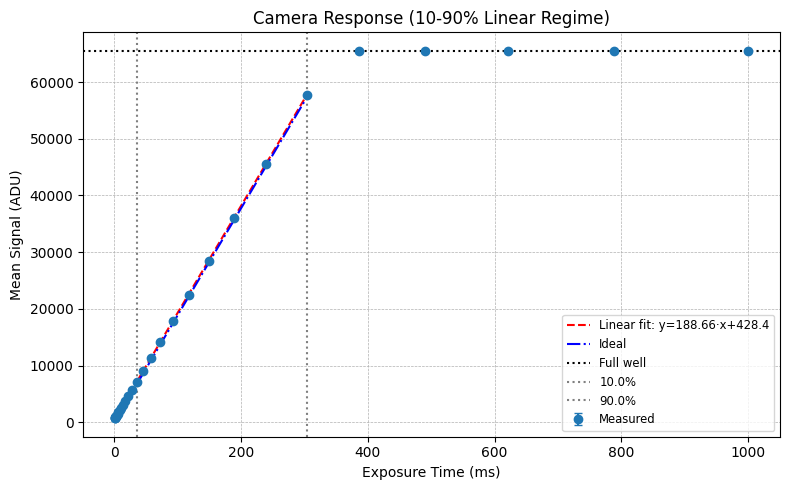

In [77]:
# Open serial connection
ser = serial.Serial(
    port='COM5',         # Replace with your actual port
    baudrate=9600,
    bytesize=serial.EIGHTBITS,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    timeout=2,
    xonxoff=False,
    rtscts=False,
    dsrdtr=False
)

init_cmds(ser)

cam_name = "ASCOM.ASICamera2.Camera"
bit_depth = 16
num_exp = 30
num_frames = 5
exp_flat, matched_readings, img_array, exp_times = camera_with_picoam(
        cam_name = cam_name,
        exp_low = 0.001,
        exp_high = 1.0,
        num_exp= num_exp,
        num_frames= num_frames,
        img_shape= (1000,1000),
        save_path= "C:/Users/Jonah/fits_imgs",
        bit_depth=bit_depth
    )
# 1) Compute per‐frame signal matrix of shape (num_exp, num_frames)
#    directly from the 4D img_array
# img_array.shape == (num_exp, num_frames, H, W)
per_frame = img_array.mean(axis=(2,3))   # shape → (num_exp, num_frames)

# 2) Compute mean ± 1σ across the num_frames for each exposure
mean_signal = per_frame.mean(axis=1)     # shape → (num_exp,)
std_signal  = per_frame.std(axis=1)      # shape → (num_exp,)

# 3) Prepare your x‐axis: exposure time in ms
exp_ms = exp_times * 1e3                 # also length num_exp

# 4) Identify the linear regime
bit_max = 2**bit_depth - 1
# indices of exposures that are within [10%, 90%] of full‐well
min_percent = 0.10
max_percent = 0.90
lin_idx = np.where(
    (mean_signal >= min_percent*bit_max) &
    (mean_signal <= max_percent*bit_max)
)[0]

# 5) Fit a line in that regime
m, b   = np.polyfit(exp_ms[lin_idx], mean_signal[lin_idx], 1)
fit_fn = np.poly1d((m, b))

# 6) Plot everything
plt.figure(figsize=(8,5))

# a) data with error bars
plt.errorbar(exp_ms, mean_signal, yerr=std_signal,
             fmt='o', capsize=3, label='Measured')

# b) linear fit over the [10,90]% region
x_fit = np.linspace(exp_ms[lin_idx[0]], exp_ms[lin_idx[-1]], 100)
plt.plot(x_fit, fit_fn(x_fit), 'r--',
         label=f'Linear fit: y={m:.2f}·x+{b:.1f}')

# c) ideal response through origin
plt.plot(x_fit, m*x_fit, 'b-.', label='Ideal')

# d) saturation and threshold markers
plt.axhline(bit_max,    color='k', linestyle=':', label='Full well')
plt.axvline(exp_ms[lin_idx[0]], color='gray', linestyle=':', label=f'{min_percent*100:.1f}%')
plt.axvline(exp_ms[lin_idx[-1]],color='gray', linestyle=':', label=f'{max_percent*100:.1f}%')

# plt.xscale('log')  # optional
plt.xlabel('Exposure Time (ms)')
plt.ylabel('Mean Signal (ADU)')
plt.title(f'Camera Response ({min_percent*100:.0f}-{max_percent*100:.0f}% Linear Regime)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True, ls='--', lw=0.5)
plt.tight_layout()
plt.show()